# analyze 30 s data sets

### Condensed version of things for Jullian

In [78]:
%matplotlib inline
import os
#import computeDEL
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy.io as spio
#import wrapFunctions #import wrap180, wrap360, wrapList
import glob
import pandas as pd
#from ggplot import *
from scipy import stats

## Parameters

In [79]:
dataFolder = 'data30'
dataFile  = os.path.join(dataFolder,'dataFile.csv')

figFolder = 'signalPlots_Update'
maxminFolder = 'maxminPlots_Update'

lowTurb = False # Limit by TI?
tiLim = 6. # % TI to limit to 

## Load the data file

In [80]:
df = pd.read_csv(dataFile)

## Analysis

In [81]:
# Make output folder
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
if not os.path.exists(maxminFolder):
    os.makedirs(maxminFolder)

In [82]:
# Add a channel which is cut wind speed and direction
binEdge = np.arange(3.,20.)
binEdge = np.arange(3.,16.)
df['windRange'] = pd.cut(df.WS1_90m_mean,binEdge,right=True)

binEdge = np.arange(-45.,55.,5) - 2.5
binLabel = range(-45,50,5)
#df['dirBin'] = pd.cut(df.apparantVane_mean,binEdge,right=True,labels=binLabel)
df['dirBin'] = pd.cut(df.WD_Nacelle_mean - 180.,binEdge,right=True,labels=binLabel)

In [83]:
# Limit by TI if told to:
if lowTurb:
    df['TI'] = 100. * df.WS1_90m_std / df.WS1_90m_mean
    df = df[df.TI < tiLim]
    df = df.drop('TI',axis=1)

In [84]:
# Limit to regions with low nacelle error for first plot, which compares the measurement
# between turbine and met mast
dfTemp = df[ abs(df.WD_Nacelle_mean - 180.) < 5.]
dfTemp = dfTemp[ dfTemp.ApparentPower_mean > 150.] # Make sure some power being produced
dfTemp.shape

(11710, 132)

/usr/local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


6.12844458875185


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


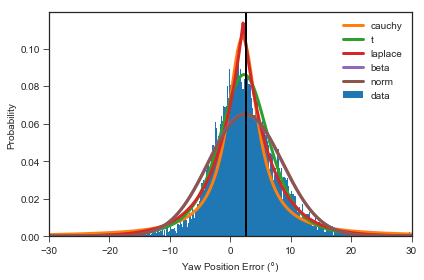

In [97]:
dfTemp['turbinePos'] = dfTemp.Yaw_Encoder_mean + (df.WD_Nacelle_mean - 180.)
fig, ax = plt.subplots()
unclearnerrs = dfTemp.WD1_87m_mean-dfTemp.turbinePos
yawerrs = unclearnerrs[~(np.abs(unclearnerrs)>30)]
#yawerrs -= np.mean(yawerrs)
ax.hist(yawerrs, bins=300, normed=1, label='data')
x = np.arange(-30, 30, .01)

distrNameList = ['cauchy', 't', 'laplace', 'beta', 'norm']
for distrName in distrNameList:
    distr = getattr(stats.distributions, distrName)
    param = distr.fit(yawerrs)
    pdf = distr.pdf(x, *param)
    ax.plot(x, pdf, lw=3, label=distrName)

ax.set_xlim([-30,30])
ax.axvline(yawerrs.mean(), lw=2, c='k')
ax.set_xlabel("Yaw Position Error" r" ($\degree$)")
ax.set_ylabel("Probability")
plt.legend()
print (np.std(yawerrs))